# Understanding the Situation

# 0.0 IMPORTS

## 0.1 Libraries

In [ ]:
#!pip install psycopg2

In [3]:
import random
import warnings

import numpy        as np
import pandas       as pd
import scipy.stats  as ss

import seaborn           as sns
import matplotlib.pyplot as plt

from IPython.display         import Image
from IPython.core.display    import HTML

from sklearn.metrics         import accuracy_score, balanced_accuracy_score, cohen_kappa_score, classification_report
from sklearn.ensemble        import RandomForestClassifier
from sklearn.model_selection import train_test_split

from scikitplot.metrics      import plot_confusion_matrix


import sys
sys.path.append('../')
## My Functions
from modules.postgres import Postgres

## 0.2 Helper Functions

### 0.2.1 Notebook Config

In [4]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container { width:85% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    warnings.filterwarnings("ignore")
    
    sns.set()

In [5]:
jupyter_settings()

### 0.2.2 Functions

In [6]:
def statistical_summary(num_attributes):
    ### Central Tendency -> Mean, Median, Mode
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
    ct3 = pd.DataFrame(ss.mode(num_attributes)[0])
    ct3.columns = ct1.columns

    ### Dispersion -> std, min, max, range, skew, kurtosis, rsd
    d1 = pd.DataFrame(num_attributes.apply(np.std)).T
    d2 = pd.DataFrame(num_attributes.apply(min)).T
    d3 = pd.DataFrame(num_attributes.apply(max)).T
    d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    d7 = d1 / ct1
    
    # Quantile
    q05 = pd.DataFrame(num_attributes.quantile(0.05)).T
    q10 = pd.DataFrame(num_attributes.quantile(0.10)).T
    q25 = pd.DataFrame(num_attributes.quantile(0.25)).T
    q75 = pd.DataFrame(num_attributes.quantile(0.75)).T
    q90 = pd.DataFrame(num_attributes.quantile(0.90)).T
    q95 = pd.DataFrame(num_attributes.quantile(0.95)).T

    # Concatenate
    m = pd.concat([d2, d3, d4, ct3, ct1, ct2, q05, q10, q25, q75, q90, q95, d1, d7, d5, d6]).T.reset_index()
    m.columns = ['Attributes', 'Mni', 'Max', 'Range', 'Mode', 'Mean', 'Median', '5%', '10%', '25%', '75%', '90%', '95%', 'Std','Relative Std', 'Skew', 'Kurtosis']
    
    return m

## 0.3 Loading data

In [7]:
# class instantiation
pg = Postgres()

# schemas and tables
schema = pg.inspect_schema()
schema

{'pa004': ['users', 'vehicle', 'insurance']}

In [8]:
import inspect
print(inspect.getdoc(pg.inspect_schema))

Performs the inspection of the database to check the schemas and their respective tables in each schema

Paramns
-------

engine: postgres engine

Return
------
Returns a dictionary where the keys are the schemas (the information_schema and public schemas are filtered)
and the names of the tables contained in each schema as a list in the dictionary values.


In [9]:
# query table
dict_tables = pg.get_data()

In [10]:
print(inspect.getdoc(pg.get_data))

Perform querys of all tables of all schemas except for information_schema and public

Return
------
Returns a dictionary where the keys are the tables related in the dictionary values that the insp_schema function returns.
The dictionary values are dated that contain the respective tables in the postgres


### 0.3.1 Table Users

In [11]:
users = dict_tables['users']
users.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


### 0.3.2 Table Vehicle

In [12]:
vehicle = dict_tables['vehicle']
vehicle.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


### 0.3.3 Table Insurance

In [13]:
insurance = dict_tables['insurance']
insurance.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


### 0.3.4 Merge Dataset

In [14]:
df_train = pd.merge(users, vehicle, how="inner", on="id")
df_train = pd.merge(df_train, insurance, how="inner", on="id")

# 1.0 DATA DESCRIPTION

In [15]:
df01 = df_train.copy()
df01.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,1,Male,44,28.0,26.0,1,> 2 Years,Yes,0,40454.0,217,1
1,2,Male,76,3.0,26.0,1,1-2 Year,No,0,33536.0,183,0
2,3,Male,47,28.0,26.0,1,> 2 Years,Yes,0,38294.0,27,1
3,4,Male,21,11.0,152.0,1,< 1 Year,No,1,28619.0,203,0
4,5,Female,29,41.0,152.0,1,< 1 Year,No,1,27496.0,39,0


## 1.1 Data Dimensions

In [16]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 381109
Number of Columns: 12


## 1.2 Data Type

In [17]:
df01.dtypes

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.3 NA Check

In [22]:
df01.isnull().sum()

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## ~~1.4 Change Data type~~

## 1.5 Check Balanced Data

In [18]:
df01['response'].value_counts(normalize=True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.6 Descriptive Analysis

In [19]:
# numerical
num_attributes = df01.select_dtypes(include=['int64', 'float64'])
# categorical
cat_attributes = df01.select_dtypes(exclude=['int64', 'float64'])

### 1.6.1 Numerical Attributes

In [20]:
statistical_summary(num_attributes.drop('id', axis=1))

,Attributes,Mni,Max,Range,Mode,Mean,Median,5%,10%,25%,75%,90%,95%,Std,Relative Std,Skew,Kurtosis
0,age,20.0,85.0,65.0,24.0,38.822584,36.0,21.0,22.0,25.0,49.0,62.0,69.0,15.511591,0.399551,0.672539,-0.565655
1,region_code,0.0,52.0,52.0,28.0,26.388807,28.0,5.0,8.0,15.0,35.0,46.0,47.0,13.229871,0.501344,-0.115266,-0.867857
2,policy_sales_channel,1.0,163.0,162.0,152.0,112.034295,133.0,26.0,26.0,29.0,152.0,156.0,160.0,54.203924,0.483815,-0.900008,-0.970810
3,driving_license,0.0,1.0,1.0,1.0,0.997869,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.046109,0.046208,-21.595182,464.354302
4,previously_insured,0.0,1.0,1.0,0.0,0.458210,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.498251,1.087384,0.167747,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,2630.0,30564.389581,31669.0,2630.0,2630.0,24405.0,39400.0,48431.0,55176.0,17213.132474,0.563176,1.766087,34.004569
6,vintage,10.0,299.0,289.0,256.0,154.347397,154.0,24.0,38.0,82.0,227.0,270.0,285.0,83.671194,0.542097,0.003030,-1.200688
7,response,0.0,1.0,1.0,0.0,0.122563,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.327935,2.675639,2.301906,3.298788


 Most 50% of customer don't have vehicles insurance
 
 Mean value of Health Insurance is about 30k
 All customers have less 1 year on Insurance All, being 75% had 227 days
 Most 75% of customers don't have interest to buy a vehicle insurance
 Most customer are between 25 and 49 years old
 Most 75% of customer have driver license
 
 
 Most customer are Male
 Most customers vehicles age is less 2 years
 About 50% of customer has vehicles damage on past

### 1.6.2 Categorical Attributes

In [21]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


# 2.0 Feature Engineering

In [23]:
df02 = df01.copy()

# 3.0 Data Filtering

In [24]:
df03 = df02.copy()

## 3.1 Filtering Rows

## 3.2 Filtering Columns

In [25]:
cols_drop = ['id']
df03 = df03.drop(cols_drop, axis=1)

# 4.0 Balanced Dataset

In [27]:
df04 = df03.copy()

## 4.1 SMOTE + TOMEKLINK

# 5.0 Exploratory Data Analysis (EDA)

In [28]:
df05_u = df04.copy()
df05 = df04.copy() ### Will be changed

## 5.1 Univariate Analysis - Feature Bahaviour (Balanced Dataset)

## 5.2 Bivariate Analysis - Hypothesis Validation (Unbalanced dataset)

## 5.3 Multivariable analysis (Balanced Dataset)

### 5.3.1 Numerical

### 5.3.2 Categorical

# 6.0 Data Filtering (Attributes with High Correlation)

In [29]:
# cols_drop = ['']
# df06 = df05.drop(cols_drop, axis=1)

df06 = df05.copy() ### will be changed

# 7.0 Data Preparation

In [30]:
# Numerical
num_attributes = df06.select_dtypes(include=['int64', 'float64'])
# Categorical
cat_attributes = df06.select_dtypes(exclude=['int64', 'float64'])

## 7.1 Rescaling

## 7.2 Encoding

In [31]:
# Dummy variable
df07_dummy = pd.get_dummies(cat_attributes)

# Join id and country_destination
df07 = pd.concat([num_attributes, df07_dummy], axis=1)

## 7.3 Transformation

# 8.0 Feature Selection

In [32]:
df08 = df07.copy()

## 8.? Split into Train and Validation

In [33]:
X = df08.drop('response', axis=1)
y = df08['response'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# 9.0 Machine Learning Model

## 9.1 Baseline model

### 9.1.1 Random Choices

In [34]:
response_list = y_train.drop_duplicates().sort_values().tolist()
response_weights = y_train.value_counts(normalize=True).sort_index().tolist()
k_num = y_test.shape[0]

# Random Model

yhat_random = random.choices(population=response_list,
                             weights=response_weights,
                             k=k_num)

### 9.1.2 Random Choices Performance

Accuracy: 0.7853900448689355
Balanced Accuracy: 0.5010755618729296
Kappa Score: 0.002127849369805479
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     66998
           1       0.12      0.13      0.12      9224

    accuracy                           0.79     76222
   macro avg       0.50      0.50      0.50     76222
weighted avg       0.79      0.79      0.79     76222



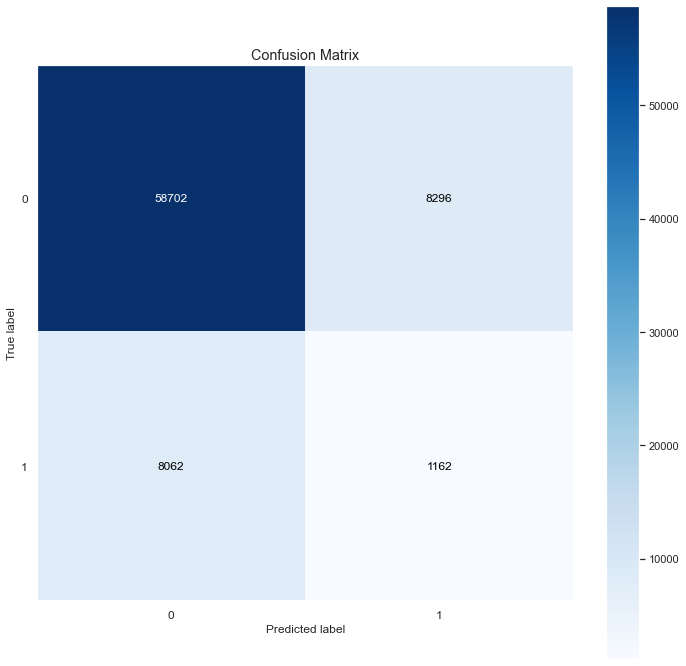

In [35]:
# Accuracy
acc_random = accuracy_score(y_test, yhat_random)
print('Accuracy: {}'.format(acc_random))

# Balanced Accuracy
balanced_acc_random = balanced_accuracy_score(y_test, yhat_random)
print('Balanced Accuracy: {}'.format(balanced_acc_random))

# Kappa Score
kappa_random = cohen_kappa_score(y_test, yhat_random)
print('Kappa Score: {}'.format(kappa_random))

# Classification Report
print(classification_report(y_test, yhat_random))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_random, normalize=False, figsize=(12, 12));

## 9.2 Machine Learning Model

### 9.2.1 Random Forest

In [36]:
# Model
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

yhat_rf = rf.predict(X_test)

### 9.2.2 Random Forest Performance

Accuracy: 0.867833433916717
Balanced Accuracy: 0.5466169224168372
Kappa Score: 0.1304899441047097
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     66998
           1       0.36      0.12      0.18      9224

    accuracy                           0.87     76222
   macro avg       0.63      0.55      0.56     76222
weighted avg       0.83      0.87      0.84     76222



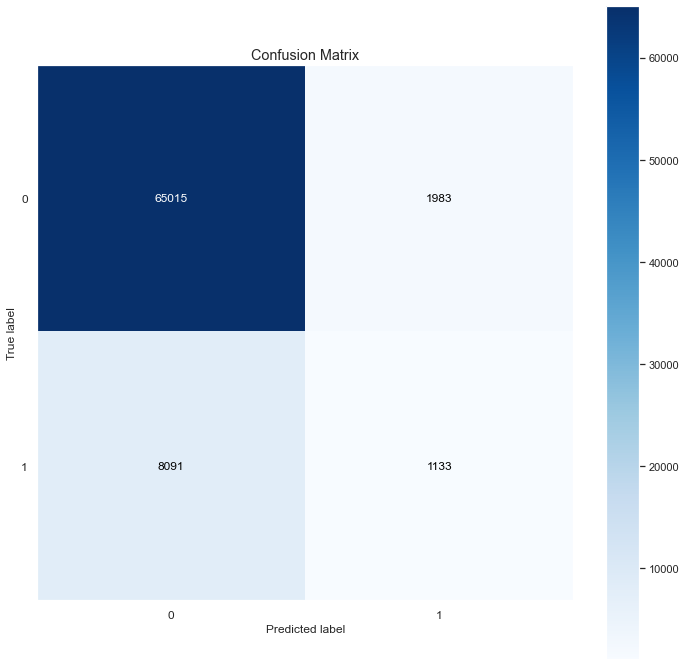

In [37]:
# Accuracy
acc_rf = accuracy_score(y_test, yhat_rf)
print('Accuracy: {}'.format(acc_rf))

# Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(y_test, yhat_rf)
print('Balanced Accuracy: {}'.format(balanced_acc_rf))

# Kappa Score
kappa_rf = cohen_kappa_score(y_test, yhat_rf)
print('Kappa Score: {}'.format(kappa_rf))

# Classification Report
print(classification_report(y_test, yhat_rf))

# Confusion matrix
plot_confusion_matrix(y_test, yhat_rf, normalize=False, figsize=(12, 12));